In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os
import shutil
import random

 Define Paths & Randomly Split Data (80:10:10)

In [ ]:
# Define dataset paths
original_dataset_dir = '/content/drive/MyDrive/full'
base_dir = '/content/fruit_data_split'

# Remove previous dataset splits (if any) to ensure random selection each time
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.makedirs(base_dir)

# Create subdirectories for train, validation, and test
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory)

# Randomly split dataset each run
for fruit_class in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, fruit_class)

    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)  # Shuffle images randomly

    train_split = int(0.8 * len(images))
    val_split = int(0.9 * len(images))  # 10% validation, remaining 10% test

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for split, image_list in zip([train_dir, val_dir, test_dir], [train_images, val_images, test_images]):
        class_split_path = os.path.join(split, fruit_class)
        os.makedirs(class_split_path, exist_ok=True)

        for image in image_list:
            src = os.path.join(class_path, image)
            dst = os.path.join(class_split_path, image)
            shutil.copyfile(src, dst)

print("Dataset successfully split into train, val, and test sets!")

Dataset successfully split into train, val, and test sets!


Create Image Data Generators


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,#Shifts images horizontally by up to 20% of width
    height_shift_range=0.2,#Shifts images vertically by up to 20% of width.
    zoom_range=0.2,
    horizontal_flip=True,

)

# Only rescale for validation & test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset
train_data = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_data = val_test_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
test_data = val_test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

num_classes = len(train_data.class_indices)
print(f"Number of fruit classes: {num_classes}")

Found 6687 images belonging to 9 classes.
Found 836 images belonging to 9 classes.
Found 839 images belonging to 9 classes.
Number of fruit classes: 9


In [ ]:
# Load MobileNetV2 without top layers
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Freeze the first 100 layers for better feature extraction
for layer in base_model.layers[:100]:
    layer.trainable = False

# Custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Define final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks to improve performance
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Train model
history = model.fit(train_data, validation_data=val_data, epochs=50, callbacks=[reduce_lr, early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 652s 3s/step - accuracy: 0.4633 - loss: 1.5651 - val_accuracy: 0.9103 - val_loss: 0.3095 - learning_rate: 1.0000e-04
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 677s 3s/step - accuracy: 0.8915 - loss: 0.3579 - val_accuracy: 0.9019 - val_loss: 0.2896 - learning_rate: 1.0000e-04
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 618s 3s/step - accuracy: 0.9293 - loss: 0.2118 - val_accuracy: 0.9306 - val_loss: 0.2537 - learning_rate: 1.0000e-04
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 620s 3s/step - accuracy: 0.9520 - loss: 0.1582 - val_accuracy: 0.9342 - val_loss: 0.2387 - learning_rate: 1.0000e-04
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 621s 3s/step - accuracy: 0.9603 - loss: 0.1247 - val_accuracy: 0.9749 - val_loss: 0.0933 - learning_rate: 1.0000e-04
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 617s 3s/step - accuracy: 0.9664 - loss: 0.1158 - val_accuracy: 0.9725 - val_loss: 0.1131 - learning_rate: 1.0000e-04
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 608s 3s/step - acc

In [ ]:
model.save('/content/drive/MyDrive/fruit_classifier_model.h5')
print("Model saved successfully!")

Model saved successfully!


27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step


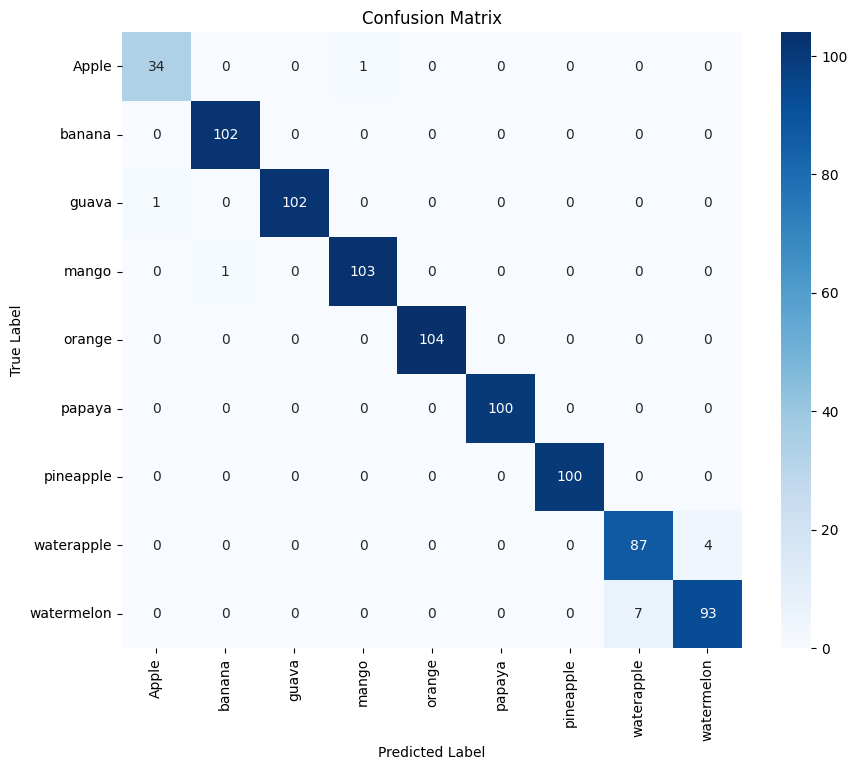

              precision    recall  f1-score   support

       Apple       0.97      0.97      0.97        35
      banana       0.99      1.00      1.00       102
       guava       1.00      0.99      1.00       103
       mango       0.99      0.99      0.99       104
      orange       1.00      1.00      1.00       104
      papaya       1.00      1.00      1.00       100
   pineapple       1.00      1.00      1.00       100
  waterapple       0.93      0.96      0.94        91
  watermelon       0.96      0.93      0.94       100

    accuracy                           0.98       839
   macro avg       0.98      0.98      0.98       839
weighted avg       0.98      0.98      0.98       839



In [ ]:
# Evaluate on test set
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.class_indices.keys(), yticklabels=train_data.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=train_data.class_indices.keys()))

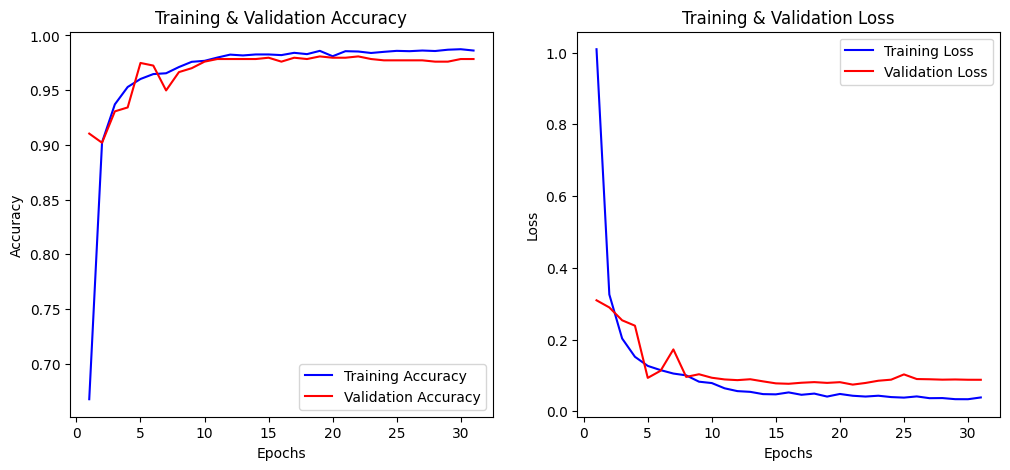

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from model.fit()
def plot_accuracy_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Accuracy Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.show()

# Call this function after training
plot_accuracy_loss(history)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define test dataset directory
test_dir = "/content/fruit_data_split/test"

# Create ImageDataGenerator for testing (No Augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Match model input size
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # Shuffle images for variety
)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

Found 839 images belonging to 9 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


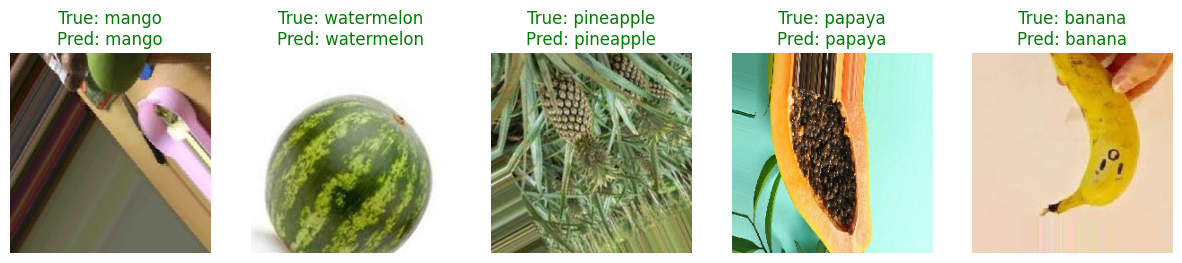

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_sample_predictions(model, test_generator, class_labels, num_images=5):
    # Get a batch of test images and labels
    test_images, test_labels = next(test_generator)  # Get batch

    plt.figure(figsize=(15, 10))

    for i in range(num_images):
        img = test_images[i]
        true_label = class_labels[np.argmax(test_labels[i])]

        # Predict
        img_array = np.expand_dims(img, axis=0)
        predictions = model.predict(img_array)
        predicted_label = class_labels[np.argmax(predictions)]

        # Plot Image with Predictions
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'True: {true_label}\nPred: {predicted_label}',
                  color='green' if true_label == predicted_label else 'red')

    plt.show()

# Call this function after defining test_generator
plot_sample_predictions(model, test_generator, class_labels)

In [ ]:
import json

# Save class labels to a file
class_labels = list(test_generator.class_indices.keys())

with open('/content/drive/MyDrive/class_labels.json', 'w') as f:
    json.dump(class_labels, f)

In [ ]:
import pickle

with open('/content/drive/MyDrive/model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)